In [1]:
import yaml
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from skopt.space import Real, Integer
from skopt import BayesSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn import tree

from matplotlib import pyplot as plt
from seaborn import heatmap

import pickle

In [2]:
# Read config file
with open("config.yaml", 'r') as configuration:
    config = yaml.safe_load(configuration)

In [3]:
# Read and concat the data
PL_20_21 = pd.read_csv('data\\PL_20_21.csv', sep=',')
PL_19_20 = pd.read_csv('data\\PL_19_20.csv', sep=',')
PL_18_19 = pd.read_csv('data\\PL_18_19.csv', sep=',')
PL_17_18 = pd.read_csv('data\\PL_17_18.csv', sep=',')
PL_16_17 = pd.read_csv('data\\PL_16_17.csv', sep=',')
BL_20_21 = pd.read_csv('data\\BL_20_21.csv', sep=',')
BL_19_20 = pd.read_csv('data\\BL_19_20.csv', sep=',')
BL_18_19 = pd.read_csv('data\\BL_18_19.csv', sep=',')
BL_17_18 = pd.read_csv('data\\BL_17_18.csv', sep=',')
BL_16_17 = pd.read_csv('data\\BL_16_17.csv', sep=',')
SP_20_21 = pd.read_csv('data\\SP_20_21.csv', sep=',')
SP_19_20 = pd.read_csv('data\\SP_19_20.csv', sep=',')
SP_18_19 = pd.read_csv('data\\SP_18_19.csv', sep=',')
SP_17_18 = pd.read_csv('data\\SP_17_18.csv', sep=',')
SP_16_17 = pd.read_csv('data\\SP_16_17.csv', sep=',')
IT_20_21 = pd.read_csv('data\\IT_20_21.csv', sep=',')
IT_19_20 = pd.read_csv('data\\IT_19_20.csv', sep=',')
IT_18_19 = pd.read_csv('data\\IT_18_19.csv', sep=',')
IT_17_18 = pd.read_csv('data\\IT_17_18.csv', sep=',')
IT_16_17 = pd.read_csv('data\\IT_16_17.csv', sep=',')

data = pd.concat([PL_20_21,PL_19_20,PL_18_19,PL_17_18,PL_16_17,
                  BL_20_21,BL_19_20,BL_18_19,BL_17_18,BL_16_17,
                  SP_20_21,SP_19_20,SP_18_19,SP_17_18,SP_16_17,
                  IT_20_21,IT_19_20,IT_18_19,IT_17_18,IT_16_17])
data = data.reset_index(drop=True)
data

,Date,HomeTeam,AwayTeam,FTR,h_course,d_course,a_course,h_pts_avg3,h_pts_avg5,h_pts_avg7,...,a_rc_min7,a_pts_per_math,a_gz,a_gs,a_sh_od,a_sh_ot,a_cw,a_cb,a_pozycja,position_dst
0,2020-09-12,Crystal Palace,Southampton,H,3.10,3.25,2.37,1.000000,1.2,0.857143,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-09-12,Liverpool,Leeds,H,1.28,6.00,9.50,3.000000,3.0,2.428571,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-09-12,West Ham,Newcastle,A,2.15,3.40,3.40,2.333333,2.0,1.428571,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-09-13,West Brom,Leicester,A,3.80,3.60,1.95,0.000000,0.2,0.285714,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-09-13,Tottenham,Everton,A,1.83,3.60,4.33,2.000000,1.8,1.857143,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7205,2017-05-28,Inter,Udinese,H,1.33,5.50,8.50,2.000000,1.2,1.000000,...,0,1.216216,1.216216,1.378378,11.270270,12.297297,5.540541,4.945946,13.0,5.0
7206,2017-05-28,Palermo,Empoli,H,6.00,4.33,1.53,2.000000,2.0,1.571429,...,2,0.864865,0.756757,1.594595,9.324324,16.054054,5.702703,4.027027,18.0,1.0
7207,2017-05-28,Roma,Genoa,H,1.06,15.00,34.00,3.000000,2.4,2.285714,...,0,0.972973,0.972973,1.648649,11.621622,12.270270,4.540541,5.216216,16.0,14.0
7208,2017-05-28,Sampdoria,Napoli,A,15.00,7.50,1.18,0.666667,0.6,0.428571,...,0,2.243243,2.432432,1.000000,17.513514,10.027027,6.162162,4.540541,3.0,7.0


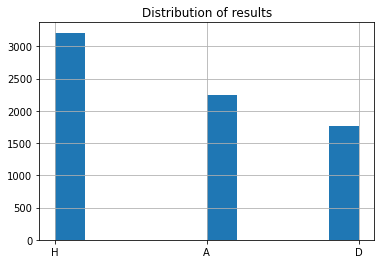

In [4]:
# Histogram - target variable
data['FTR'].hist()
plt.title('Distribution of results')
plt.show()

In [5]:
# Dictionary for mapping target
str2idx = {'H':0, 'D':1, 'A':2}
idx2str = {0:'H', 1:'D', 2:'A'}
dicts2translate = {'str2idx' : str2idx,
                   'idx2str' : idx2str }

data = data.replace({'FTR': str2idx})

data_label = data['FTR']
data = data.drop(['FTR','Date','HomeTeam','AwayTeam'], axis=1)
data

,h_course,d_course,a_course,h_pts_avg3,h_pts_avg5,h_pts_avg7,h_pts_std3,h_pts_std5,h_pts_std7,h_pts_wz3,...,a_rc_min7,a_pts_per_math,a_gz,a_gs,a_sh_od,a_sh_ot,a_cw,a_cb,a_pozycja,position_dst
0,3.10,3.25,2.37,1.000000,1.2,0.857143,1.414214,1.469694,1.355262,1.414214,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.28,6.00,9.50,3.000000,3.0,2.428571,0.000000,0.000000,0.903508,0.000000,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.15,3.40,3.40,2.333333,2.0,1.428571,0.942809,1.264911,1.399708,0.404061,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.80,3.60,1.95,0.000000,0.2,0.285714,0.000000,0.400000,0.451754,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.83,3.60,4.33,2.000000,1.8,1.857143,1.414214,1.469694,1.355262,0.707107,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7205,1.33,5.50,8.50,2.000000,1.2,1.000000,1.414214,1.469694,1.309307,0.707107,...,0,1.216216,1.216216,1.378378,11.270270,12.297297,5.540541,4.945946,13.0,5.0
7206,6.00,4.33,1.53,2.000000,2.0,1.571429,1.414214,1.264911,1.293626,0.707107,...,2,0.864865,0.756757,1.594595,9.324324,16.054054,5.702703,4.027027,18.0,1.0
7207,1.06,15.00,34.00,3.000000,2.4,2.285714,0.000000,1.200000,1.160577,0.000000,...,0,0.972973,0.972973,1.648649,11.621622,12.270270,4.540541,5.216216,16.0,14.0
7208,15.00,7.50,1.18,0.666667,0.6,0.428571,0.471405,0.489898,0.494872,0.707107,...,0,2.243243,2.432432,1.000000,17.513514,10.027027,6.162162,4.540541,3.0,7.0


In [6]:
data = data.drop(['h_course','d_course','a_course'], axis=1)

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, data_label, test_size=0.30, random_state=20)

In [8]:
model = xgb.XGBClassifier(objective='multi:softmax',
                          num_class=3,
                          use_label_encoder=False)

In [9]:
params = {
        'learning_rate': Real(0.01, 0.2),
        'n_estimators': Integer(30, 100),
        'min_child_weight': Integer(10, 600),
        'gamma': Real(0,20),
        'colsample_bytree': Real(0.6, 0.95),
        'subsample': Real(0.85, 1),
        'max_depth': Integer(2,3),
        'lambda': Real(0,20),
        'alpha': Real(0,20)
        }

In [10]:
# BAYESIAN OPTIMIZATION
bayes_optim = BayesSearchCV(estimator=model,
                            search_spaces=params,
                            n_iter = 20,
                            n_jobs=-1,
                            cv=5,
                            verbose=1,
                            random_state=19)

bayes_optim.fit(X_train, y_train)


print('\nBEST PARAMETERS:', bayes_optim.best_params_, '\n')

print('BEST SCORE:', bayes_optim.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [11]:
# Manualy hiperparameters tuning
#bayes_optim.best_params_['learning_rate'] = 0.2

In [12]:
xgb_model = bayes_optim.best_estimator_

xgb_model.fit(X_train, y_train,
              eval_set = [(X_train, y_train), (X_test, y_test)],
              eval_metric = ['auc', 'mlogloss'],
              verbose=True)

[0]	validation_0-auc:0.65097	validation_0-mlogloss:1.08749	validation_1-auc:0.62744	validation_1-mlogloss:1.08848
[1]	validation_0-auc:0.66832	validation_0-mlogloss:1.07755	validation_1-auc:0.64542	validation_1-mlogloss:1.07943
[2]	validation_0-auc:0.67142	validation_0-mlogloss:1.06878	validation_1-auc:0.64581	validation_1-mlogloss:1.07150
[3]	validation_0-auc:0.67919	validation_0-mlogloss:1.06043	validation_1-auc:0.65152	validation_1-mlogloss:1.06427
[4]	validation_0-auc:0.68166	validation_0-mlogloss:1.05305	validation_1-auc:0.65549	validation_1-mlogloss:1.05757
[5]	validation_0-auc:0.68593	validation_0-mlogloss:1.04631	validation_1-auc:0.65884	validation_1-mlogloss:1.05184
[6]	validation_0-auc:0.68755	validation_0-mlogloss:1.04053	validation_1-auc:0.66184	validation_1-mlogloss:1.04669
[7]	validation_0-auc:0.69123	validation_0-mlogloss:1.03495	validation_1-auc:0.66495	validation_1-mlogloss:1.04201
[8]	validation_0-auc:0.69382	validation_0-mlogloss:1.02968	validation_1-auc:0.66675	vali

XGBClassifier(alpha=3.288270359173991, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6219848240695033, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='', lambda=20.0,
              learning_rate=0.08613188803959024, max_delta_step=0, max_depth=2,
              min_child_weight=346, missing=nan, monotone_constraints='()',
              n_estimators=59, n_jobs=8, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=3.28827047,
              reg_lambda=20, scale_pos_weight=None, subsample=1.0,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

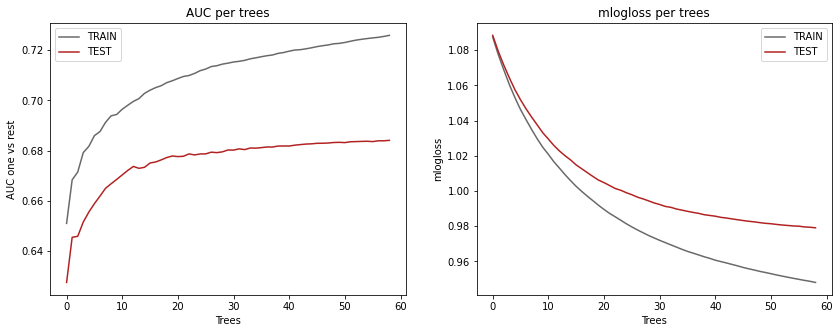

In [13]:
eval_results = xgb_model.evals_result()
x_axis = range(0, len(eval_results['validation_0']['auc']))

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(x_axis, eval_results['validation_0']['auc'], label='TRAIN', color='dimgrey')
ax[0].plot(x_axis, eval_results['validation_1']['auc'], label='TEST', color='firebrick')
ax[0].legend()
ax[0].set_xlabel('Trees')
ax[0].set_ylabel('AUC one vs rest')
ax[0].set_title('AUC per trees')

ax[1].plot(x_axis, eval_results['validation_0']['mlogloss'], label='TRAIN', color='dimgrey')
ax[1].plot(x_axis, eval_results['validation_1']['mlogloss'], label='TEST', color='firebrick')
ax[1].legend()
ax[1].set_xlabel('Trees')
ax[1].set_ylabel('mlogloss')
ax[1].set_title('mlogloss per trees')
plt.show()

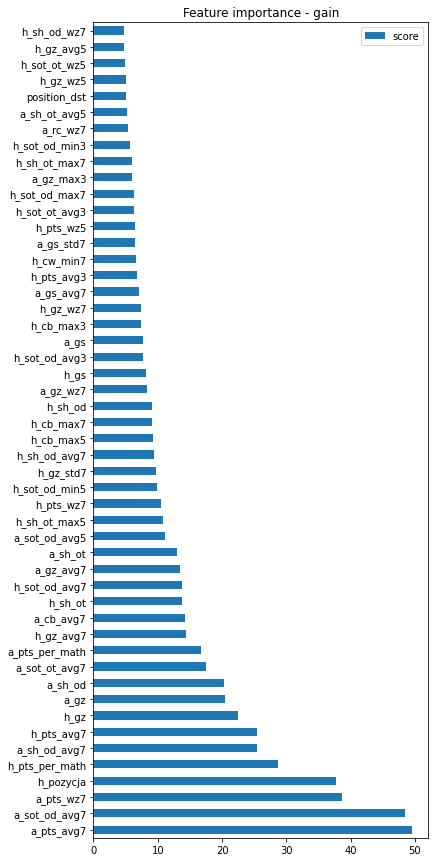

In [14]:
# Feature importance
feature_important = xgb_model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data_score = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)[:50]
data_score.plot(kind='barh', figsize=(6,15))
plt.title('Feature importance - gain')
plt.show()

In [15]:
train_probabilities = pd.DataFrame(xgb_model.predict_proba(X_train))
train_probabilities['FTR'] = train_probabilities.idxmax(axis = 1)

test_probabilities = pd.DataFrame(xgb_model.predict_proba(X_test))
test_probabilities['FTR'] = test_probabilities.idxmax(axis = 1)


# BALANCED ACCURACY
print('--- BALANCED ACCURACY ---')
print('TRAIN:', balanced_accuracy_score(np.array(y_train), np.array(train_probabilities['FTR'])))
print(' TEST:', balanced_accuracy_score(np.array(y_test), np.array(test_probabilities['FTR'])))

--- BALANCED ACCURACY ---
TRAIN: 0.4731094401222089
 TEST: 0.461009198547831


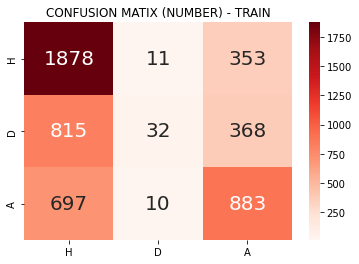

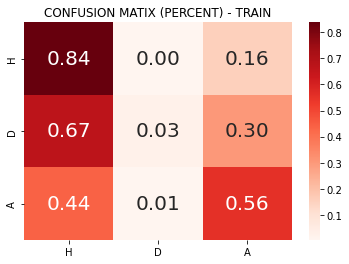

In [16]:
# TRAIN
heatmap(confusion_matrix(np.array(y_train), np.array(train_probabilities['FTR'])),
       annot=True,
       fmt='.0f',
       annot_kws={"fontsize":20},
       cmap='Reds',
       xticklabels=['H','D','A'],
       yticklabels=['H','D','A'])
plt.title('CONFUSION MATIX (NUMBER) - TRAIN')
plt.show()

heatmap(confusion_matrix(np.array(y_train), np.array(train_probabilities['FTR']), normalize='true'),
       annot=True,
       fmt='.2f',
       annot_kws={"fontsize":20},
       cmap='Reds',
       xticklabels=['H','D','A'],
       yticklabels=['H','D','A'])
plt.title('CONFUSION MATIX (PERCENT) - TRAIN')
plt.show()

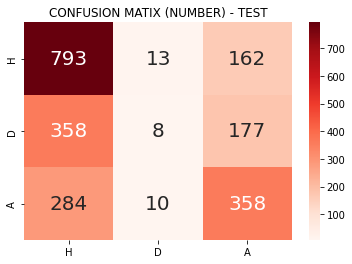

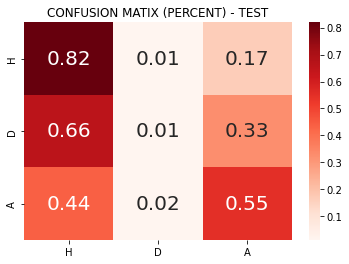

In [17]:
# TEST
heatmap(confusion_matrix(np.array(y_test), np.array(test_probabilities['FTR'])),
       annot=True,
       fmt='.0f',
       annot_kws={"fontsize":20},
       cmap='Reds',
       xticklabels=['H','D','A'],
       yticklabels=['H','D','A'])
plt.title('CONFUSION MATIX (NUMBER) - TEST')
plt.show()

heatmap(confusion_matrix(np.array(y_test), np.array(test_probabilities['FTR']), normalize='true'),
       annot=True,
       fmt='.2f',
       annot_kws={"fontsize":20},
       cmap='Reds',
       xticklabels=['H','D','A'],
       yticklabels=['H','D','A'])
plt.title('CONFUSION MATIX (PERCENT) - TEST')
plt.show()

In [24]:
train_probabilities = pd.DataFrame(xgb_model.predict_proba(X_train))

test_probabilities = pd.DataFrame(xgb_model.predict_proba(X_test))

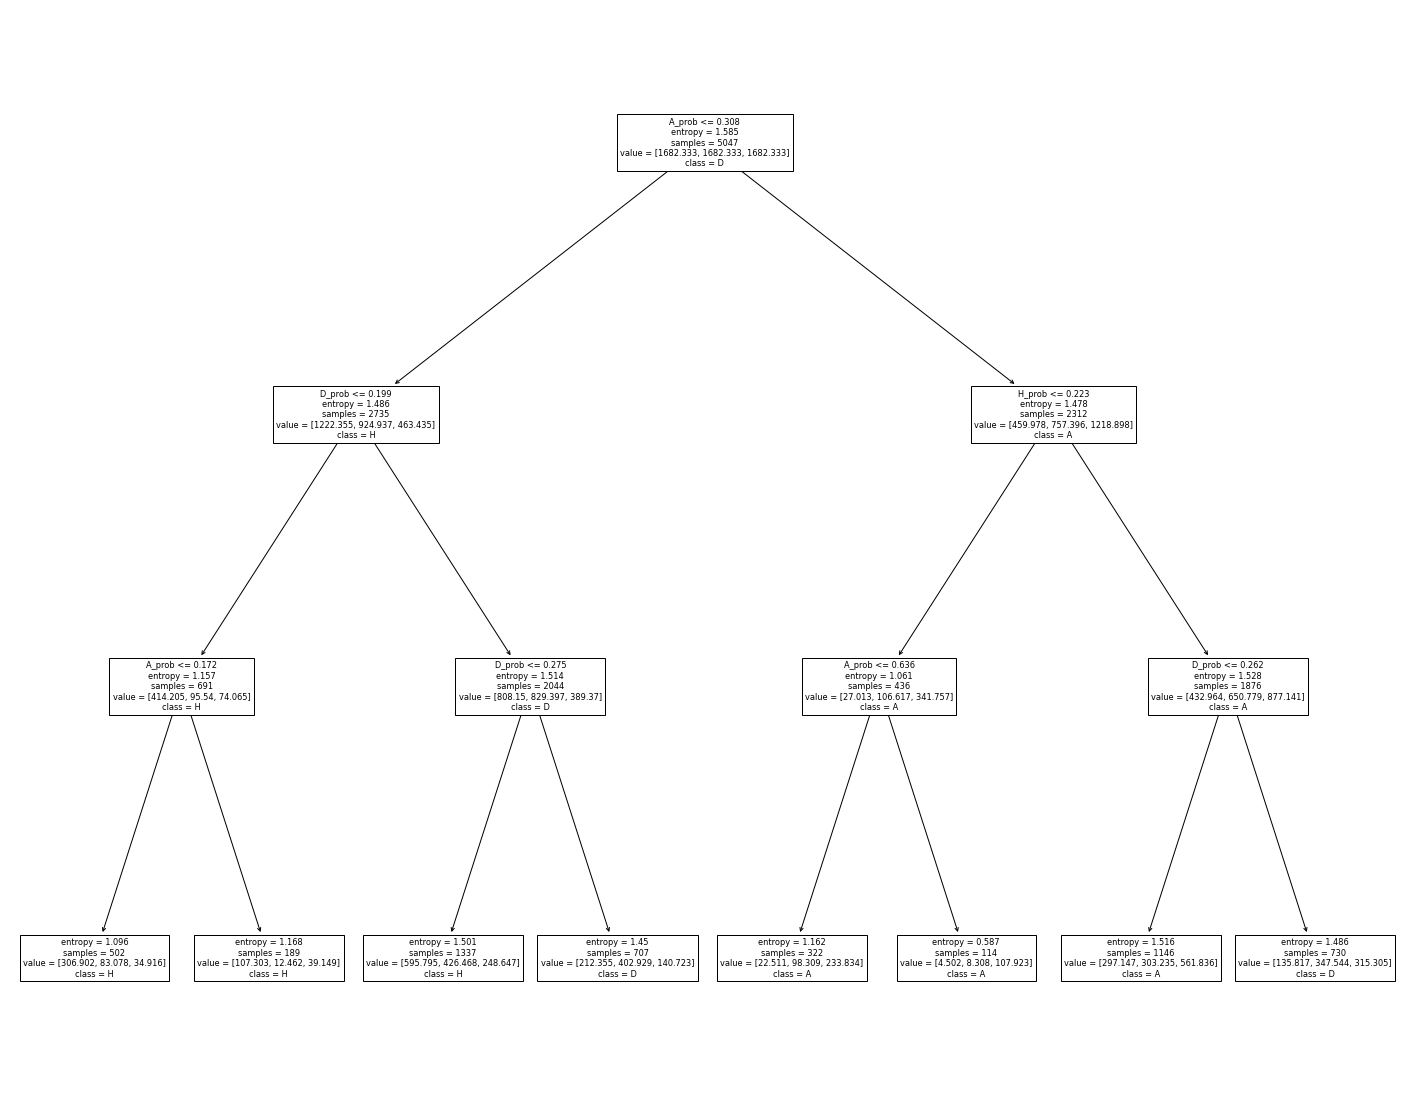

In [30]:
# Decision tree
decision_tree = DecisionTreeClassifier(criterion='entropy',
                             class_weight = 'balanced',
                             max_depth = 3,
                             min_samples_leaf = 0.01
                            )
decision_tree.fit(train_probabilities, np.array(y_train))

# Plot tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree, 
                   feature_names=['H_prob','D_prob','A_prob'],
                   class_names=['H','D','A'])

In [31]:
# Predictions after decision tree
tree_preds_train = decision_tree.predict(train_probabilities)
tree_preds_test = decision_tree.predict(test_probabilities)

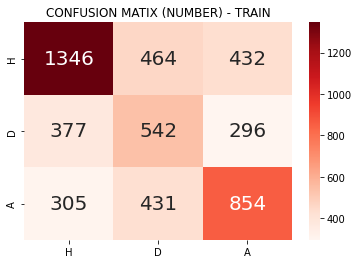

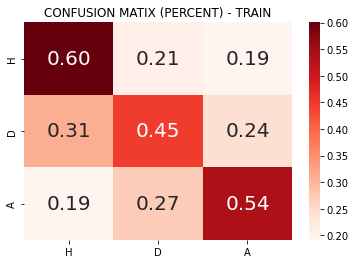

In [32]:
heatmap(confusion_matrix(np.array(y_train), np.array(tree_preds_train)),
       annot=True,
       fmt='.0f',
       annot_kws={"fontsize":20},
       cmap='Reds',
       xticklabels=['H','D','A'],
       yticklabels=['H','D','A'])
plt.title('CONFUSION MATIX (NUMBER) - TRAIN')
plt.show()

heatmap(confusion_matrix(np.array(y_train), np.array(tree_preds_train), normalize='true'),
       annot=True,
       fmt='.2f',
       annot_kws={"fontsize":20},
       cmap='Reds',
       xticklabels=['H','D','A'],
       yticklabels=['H','D','A'])
plt.title('CONFUSION MATIX (PERCENT) - TRAIN')
plt.show()

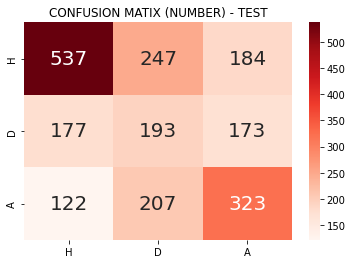

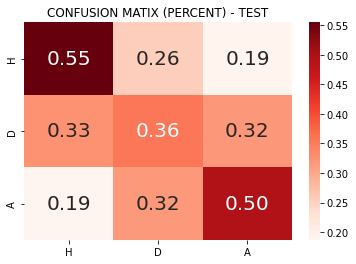

In [33]:
heatmap(confusion_matrix(np.array(y_test), np.array(tree_preds_test)),
       annot=True,
       fmt='.0f',
       annot_kws={"fontsize":20},
       cmap='Reds',
       xticklabels=['H','D','A'],
       yticklabels=['H','D','A'])
plt.title('CONFUSION MATIX (NUMBER) - TEST')
plt.show()

heatmap(confusion_matrix(np.array(y_test), np.array(tree_preds_test), normalize='true'),
       annot=True,
       fmt='.2f',
       annot_kws={"fontsize":20},
       cmap='Reds',
       xticklabels=['H','D','A'],
       yticklabels=['H','D','A'])
plt.title('CONFUSION MATIX (PERCENT) - TEST')
plt.show()

In [34]:
# BALANCED ACCURACY
print('--- BALANCED ACCURACY ---')
print('TRAIN:', balanced_accuracy_score(np.array(y_train), np.array(tree_preds_train)))
print(' TEST:', balanced_accuracy_score(np.array(y_test), np.array(tree_preds_test)))

--- BALANCED ACCURACY ---
TRAIN: 0.5278514258274892
 TEST: 0.4685278733229943


In [35]:
# Save model and components
pickle.dump(xgb_model, open('model\\xgb_model.pkl', "wb"))
pickle.dump(decision_tree, open('model\\tree_model.pkl', "wb"))
pickle.dump(dicts2translate, open('model\\dicts2translate.pkl', "wb"))